In [1]:
import sys
import fiona
import numpy as np
import pandas as pd
import xarray as xr
import rasterio.features
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datacube import Datacube
from datacube.utils import geometry
from datacube.storage import masking
from scipy.signal import argrelextrema
from datacube.utils import geometry
import fiona
import rasterio.features

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../Scripts')
import DEAPlotting
import DEADataHandling
import BandIndices


%load_ext autoreload
%autoreload 2


# Connect to datacube
dc = Datacube(app='Flood drawdown')

# Import functions
def abline(slope, intercept, plot_kwargs):
    
    """
    Plot a line from slope and intercept
    """
    
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', **plot_kwargs) 


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Extract local minima and maxima

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, plus)
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, minus)


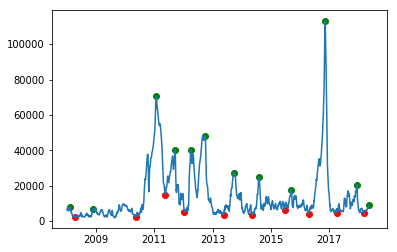

In [7]:
# Set area over which index values should be averaged
df = pd.read_csv('/home/561/rt1527/Transfer/euston_flow.csv', index_col='date', parse_dates=True, dayfirst=True)
df.rename(columns={'mean':'data'}, inplace=True)

# Subset to time limit
df = df[(df.index >= '2008-01-01') & (df.index <= '2018-12-30')]
# df = df[(df.index >= '1998-01-01') & (df.index <= '2005-12-30')]

# Find local peaks
n = 120
df['min'] = df.iloc[argrelextrema(df.data.values, np.less_equal, order=n)[0],0]
df['max'] = df.iloc[argrelextrema(df.data.values, np.greater_equal, order=n)[0],0]

# Plot results
plt.scatter(df.index, df['min'], c='r')
plt.scatter(df.index, df['max'], c='g')
plt.plot(df.index, df['data'])
plt.show()


### Identify start and end date for flood

2016-11-14 2017-04-16


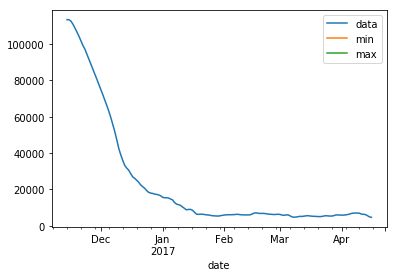

In [8]:
# Choose desired maxima; 9
maxima_i = 9

# Extract the start time based on maxima, and the end time based on subsequent minima
date_start = df.dropna(subset=['max']).index.date[maxima_i]
date_end = df.dropna(subset=['min']).truncate(before=date_start).iloc[0:1].index.date[0]
print(date_start.isoformat(), date_end.isoformat())

# Plot hydrograph between maxima and minima only
df[(df.index >= date_start.isoformat()) & (df.index <= date_end.isoformat())].plot()

# Get string format from dates
start_string, end_string = date_start.isoformat(), date_end.isoformat()

## Import WOFLs and Landsat data

In [2]:
# Start and end period
start_string, end_string = '2010-04-01', '2011-04-01'
study_area_shp = '/g/data/r78/rt1527/datasets/MacquarieMarshes_1991_E_794/Derived/redgumreeds_reeds.shp'

# Get geom from shapefile
with fiona.open(study_area_shp) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

# Create query from time period and geom
query = {'geopolygon': geom,
         'time':(start_string, end_string)}

# Extract WOFS and Landsat
WOFL = dc.load(product='wofs_albers', **query)
landsat = DEADataHandling.load_clearlandsat(dc=dc, query=query, masked_prop=0.01, 
                                            ls7_slc_off=True, apply_mask=True,
                                            mask_dict={'cloud_acca': 'no_cloud', 
                                                       'cloud_fmask': 'no_cloud',  
                                                       'cloud_shadow_acca':'no_cloud_shadow',
                                                       'cloud_shadow_fmask':'no_cloud_shadow',
                                                       'blue_saturated':False,
                                                       'green_saturated':False,
                                                       'red_saturated':False,
                                                       'nir_saturated':False,
                                                       'swir1_saturated':False,
                                                       'swir2_saturated':False,
                                                       'contiguous':True})


{'x': (939255.6406901764, 951255.6406901764), 'y': (-3836171.118514481, -3824171.118514481), 'time': ('2010-04-01', '2011-04-01'), 'crs': 'EPSG:3577'}
Loading ls5 PQ
    Loading 11 filtered ls5 timesteps
Loading ls7 PQ
    Loading 16 filtered ls7 timesteps
    Skipping ls8
Combining and sorting ls5, ls7 and ls8 data


## Identify wet and water pixels, and pixels containing valid data

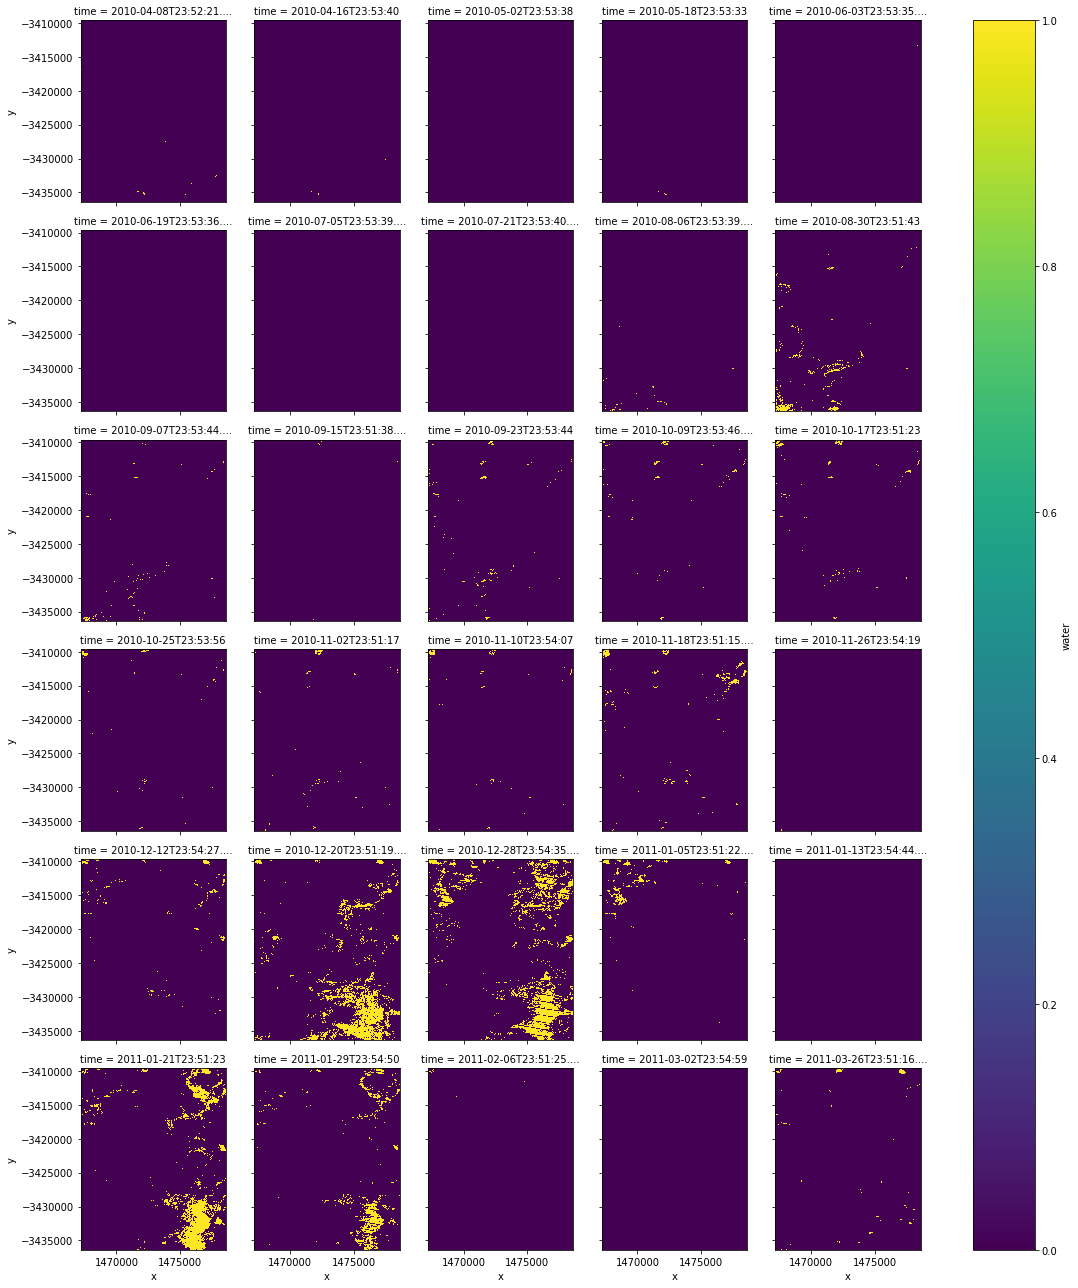

In [3]:
# Identify all wet pixels
wofls_water = masking.make_mask(WOFL, wet = True)
wofls_water.water.plot(col='time', col_wrap=5)

# Identify only WOFLs pixels with valid data 
wofls_gooddata = masking.make_mask(WOFL, 
                                   cloud=False,
                                   cloud_shadow=False,
                                   high_slope=False,
                                   noncontiguous=False,
                                   terrain_or_low_angle=False)

# Compute thresholded tasselled cap
landsat_wetness = (BandIndices.tasseled_cap(landsat, tc_bands=['wetness'], drop=True) > -600)

# Identify Landsat pixels with valid data
landsat_gooddata = ~landsat.isnull()

# Create mask from polygon to match input data
polygon_mask = rasterio.features.geometry_mask([geom.to_crs(WOFL.geobox.crs) for geoms in [geom]],
                                                out_shape=WOFL.geobox.shape,
                                                transform=WOFL.geobox.affine,
                                                all_touched=False,
                                                invert=True)

# Use polygon mask to extract only pixels of arrays within polygon
wofls_water_masked = wofls_water.where(polygon_mask)
wofls_gooddata_masked = wofls_gooddata.water.where(polygon_mask)
landsat_wetness_masked = landsat_wetness.where(polygon_mask)
landsat_gooddata_masked = landsat_gooddata.red.where(polygon_mask)

# Compute total area of polygon and total area of valid data
polygon_area = polygon_mask.sum()
wofls_gooddata_area = wofls_gooddata_masked.sum(dim=['x','y'])
landsat_gooddata_area = landsat_gooddata_masked.sum(dim=['x','y'])

## Normalise wet and water observations by the number of pixels with valid data

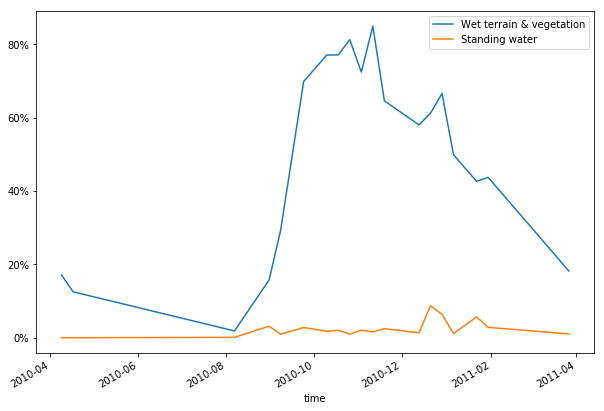

In [21]:
# Calculate normalised percentages
wofls_water_prop = wofls_water_masked.sum(dim=['x','y']) / wofls_gooddata_area
landsat_wetness_prop = landsat_wetness_masked.sum(dim=['x','y']) / landsat_gooddata_area

# Calculate percentage nodata as proportion of entire polygon study area
gooddata_prop = (wofls_gooddata_area / polygon_area)

# Keep only timesteps with greater than 70% data per timestep 
to_keep = gooddata_prop > 0.7
wofls_water_prop = wofls_water_prop.where(to_keep, drop=True)
landsat_wetness_prop = landsat_wetness_prop.where(to_keep, drop=True)

# Combine into a single dataframe
output_df = xr.auto_combine([landsat_wetness_prop, wofls_water_prop]).to_dataframe()

# Compute days since flood peak
output_df['flood_peak'] = pd.to_datetime(date_start)
output_df['days_since_peak'] = (output_df.index - output_df['flood_peak']).dt.days

# Calculate stats
x = output_df.days_since_peak.values
y = output_df.wetness.values
model = sm.OLS(y, sm.add_constant(x)).fit()

days_since=False
regression=True

if days_since:
    
    # Rename and plot
    plotting_df = output_df[['wetness', 'water', 'days_since_peak']].set_index('days_since_peak')
    plotting_df = plotting_df.rename(columns={'wetness':'Wet terrain & vegetation', 'water':'Standing water'})
    plotting_df.plot(figsize=(10, 7))
    plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
    
else:
   
    # Rename and plot
    plotting_df = output_df[['wetness', 'water']]
    plotting_df = plotting_df.rename(columns={'wetness':'Wet terrain & vegetation', 'water':'Standing water'})
    plotting_df.plot(figsize=(10, 7))
    plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])
    

# if regression:
    
#     # Add linear model line    
#     abline(model.params[1], model.params[0], plot_kwargs={'color':'black', 'alpha':0.2})

#     # # Print out the statistics
#     plt.title('Proportion of valid data pixels within polygon covered by wet terrain or water\n'  
#               '(P-value: {0:0.3f}, R-squared: {1:0.3f}, ' 
#               'Intercept: {2:0.3f}, Slope: {3:0.4f})'.format(model.pvalues[0], 
#                                                              model.rsquared, 
#                                                              model.params[0], 
#                                                              model.params[1]));


Timestamp('2010-04-08 23:52:21.500000')

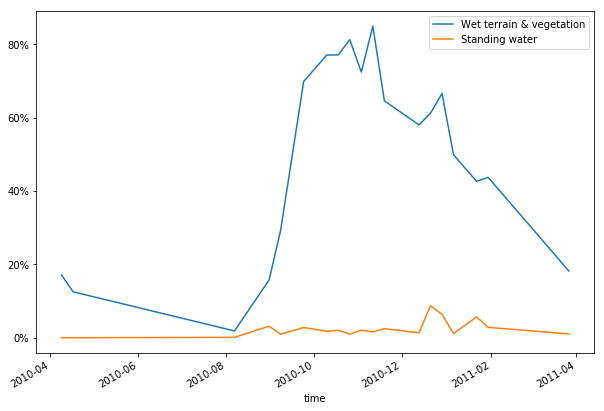

In [5]:
# Calculate normalised percentages
wofls_water_prop = wofls_water_masked.sum(dim=['x','y']) / wofls_gooddata_area
landsat_wetness_prop = landsat_wetness_masked.sum(dim=['x','y']) / landsat_gooddata_area

# Calculate percentage nodata as proportion of entire polygon study area
gooddata_prop = (wofls_gooddata_area / polygon_area)

# Keep only timesteps with greater than 70% data per timestep 
to_keep = gooddata_prop > 0.7
wofls_water_prop = wofls_water_prop.where(to_keep, drop=True)
landsat_wetness_prop = landsat_wetness_prop.where(to_keep, drop=True)

# Combine into a single dataframe
output_df = xr.auto_combine([landsat_wetness_prop, wofls_water_prop]).to_dataframe()

# Rename and plot
plotting_df = output_df[['wetness', 'water']]
plotting_df = plotting_df.rename(columns={'wetness':'Wet terrain & vegetation', 'water':'Standing water'})
plotting_df.plot(figsize=(10, 7))
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()]);
